In [2]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


#from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from darts                             import TimeSeries
from darts.models                      import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries


from pytorch_lightning.callbacks   import EarlyStopping
from darts.utils.likelihood_models import QuantileRegression
from torch.optim.lr_scheduler      import ReduceLROnPlateau
from torch.optim                   import Adam

from sklearn.metrics import mean_squared_error


In [3]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [29]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings

pdf["y"] = (pdf["Value_NE5"].values + pdf["Value_NE7"].values)/1e6 #in GWh
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

split = len(pdf)-365
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_8424\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,y
Timestamp,
2015-01-01,6.709087
2015-01-02,7.073348
2015-01-03,7.149544
2015-01-04,6.724467
2015-01-05,8.585045
...,...
2023-06-30,7.247760
2023-07-01,6.168368
2023-07-02,5.750607


In [4]:
ytrain = TimeSeries.from_dataframe(pdf_train)
ytest  = TimeSeries.from_dataframe(pdf_test)
ytotal = TimeSeries.from_dataframe(pdf)
ytotal


<TimeSeries (DataArray) (Timestamp: 3092, component: 1, sample: 1)>
array([[[6.70908714]],

       [[7.07334784]],

       [[7.14954415]],

       ...,

       [[6.23394601]],

       [[5.87963741]],

       [[6.86789264]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2015-01-01 2015-01-02 ... 2023-06-19
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [6]:
# A TorchMetric or val_loss can be used as the monitor

QUANTILES = [0.01, 0.5, 0.99]
N_SAMPLES = 100

model = NBEATSModel(
    input_chunk_length=32,
    output_chunk_length=1,
    num_stacks=8,
    num_blocks=3,
    layer_widths=64,
    dropout=0.1,
    batch_size=32,
    model_name='TestModel',
    save_checkpoints=True,
    likelihood=QuantileRegression(quantiles=QUANTILES), 
    force_reset=True
)

model.fit(series=ytrain,
          val_series=ytest,
          epochs=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 386 K 
---------------------------------------------------
385 K     Trainable params
517       Non-trainable params
386 K     Total params
3.089     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(generic_architecture=True, num_stacks=8, num_blocks=3, num_layers=4, layer_widths=64, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1, activation=ReLU, input_chunk_length=32, output_chunk_length=1, batch_size=32, model_name=TestModel, save_checkpoints=True, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x000002EB9FEC92D0>, force_reset=True)

In [7]:
y_pred = model.predict(n=len(ytest), series=ytrain).pd_series()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

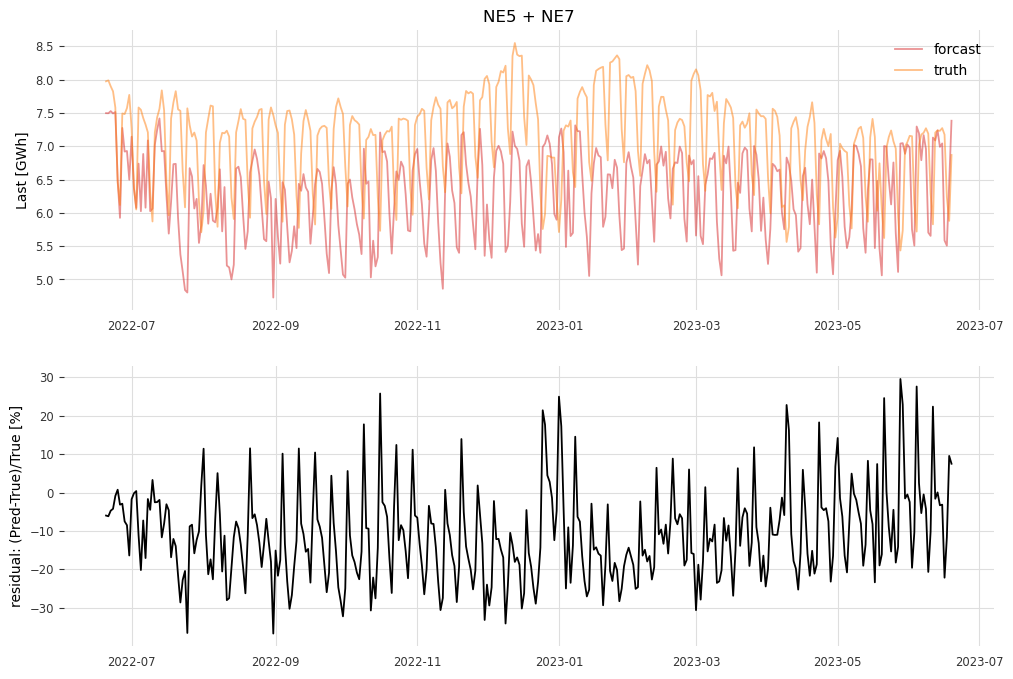

In [8]:
f, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(y_pred, color="tab:red", label="forcast", alpha=0.5)
# axes[0].plot(pdf_train[-2*365:], color="tab:blue", label="train")
axes[0].plot(pdf_test, color="tab:orange", label="truth", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(pdf_test.index, (y_pred.values - pdf_test.y.values) / (pdf_test.y.values)*100)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()


In [ ]:
rmseValue = mean_squared_error(pdf_test.y.values, y_pred.values, squared=False)
rmseValue

In [ ]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(model_es.residuals(series))